In [32]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten,Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [4]:
df=pd.read_csv('Water_dataX_mean_state_hong_kong.csv')

In [5]:
df=df[['turbidity','ss', 'dissolved_oxygen','bod5','cod','t_carbon','t_phosphorus','t_nitrogen','faecal_coliform','wqi clf']]

In [21]:
# Charger les données
data = df
cols_to_drop=["wqi clf"]
# Diviser les données en caractéristiques et cibles
X =  data.drop(cols_to_drop, axis=1)
y = data["wqi clf"].values

In [22]:
# Encoder les labels catégoriels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [23]:
from imblearn.over_sampling import SMOTE
from collections import Counter
print('Balancing the data by SMOTE - Oversampling of Minority level\n')
smt = SMOTE()
counter = Counter(y)
print('Before SMOTE', counter)
X,y = smt.fit_resample(X,y)
counter = Counter(y)
print('\nAfter SMOTE', counter)

Balancing the data by SMOTE - Oversampling of Minority level

Before SMOTE Counter({2: 14139, 1: 9063, 0: 5208, 3: 2118})

After SMOTE Counter({1: 14139, 0: 14139, 2: 14139, 3: 14139})


In [24]:
# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
# Redimensionner les données pour les convolutions 1D
X_train = X_train.values.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.values.reshape(X_test.shape[0], X_test.shape[1], 1)

In [26]:
# Convertir les labels en one-hot encoding
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Créer le modèle CNN
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=1))
model.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=1))
model.add(Flatten())
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(y_train.shape[1], activation="softmax"))

# Compiler le modèle
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [27]:
# Entraîner le modèle
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=250, batch_size=32)
print(history.history['accuracy'])
print(history.history['loss'])

Epoch 1/250
1414/1414 [==============================] - 8s 5ms/step - loss: 0.4183 - accuracy: 0.8391 - val_loss: 0.2757 - val_accuracy: 0.8896
Epoch 2/250
1414/1414 [==============================] - 6s 4ms/step - loss: 0.2698 - accuracy: 0.8966 - val_loss: 0.2316 - val_accuracy: 0.9043
Epoch 3/250
1414/1414 [==============================] - 5s 4ms/step - loss: 0.2285 - accuracy: 0.9131 - val_loss: 0.1856 - val_accuracy: 0.9295
Epoch 4/250
1414/1414 [==============================] - 6s 4ms/step - loss: 0.2137 - accuracy: 0.9188 - val_loss: 0.1826 - val_accuracy: 0.9273
Epoch 5/250
1414/1414 [==============================] - 9s 6ms/step - loss: 0.1906 - accuracy: 0.9275 - val_loss: 0.1593 - val_accuracy: 0.9388
Epoch 6/250
1414/1414 [==============================] - 6s 4ms/step - loss: 0.1737 - accuracy: 0.9331 - val_loss: 0.1680 - val_accuracy: 0.9357
Epoch 7/250
1414/1414 [==============================] - 10s 7ms/step - loss: 0.1623 - accuracy: 0.9381 - val_loss: 0.1778 - val_a

In [28]:
# Évaluer le modèle sur les données de test
score = model.evaluate(X_test, y_test)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

354/354 [==============================] - 1s 2ms/step - loss: 0.1263 - accuracy: 0.9651
Test loss: 0.1263280212879181
Test accuracy: 0.9650813341140747


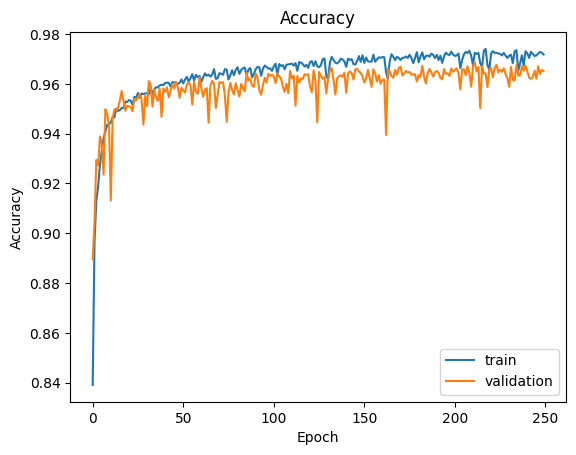

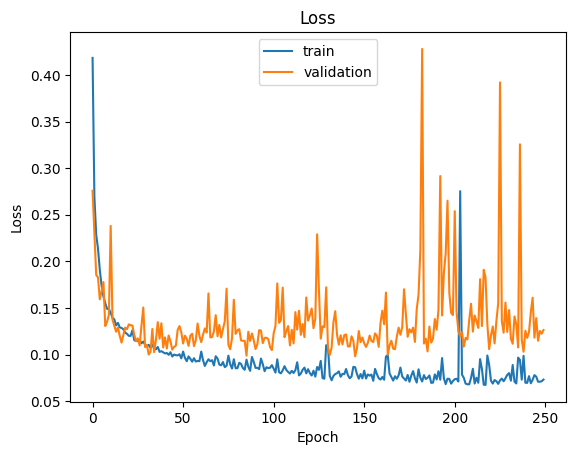

In [29]:
# Afficher les graphes d'accuracy et loss selon l'epoch
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [30]:
model.save('classification_model_cnn_hong_kong.h5')

In [33]:
# Charger le modèle CNN entraîné
model = load_model('classification_model_cnn_hong_kong.h5')

In [34]:
y_pred = model.predict(X_test,batch_size=150, verbose=0)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

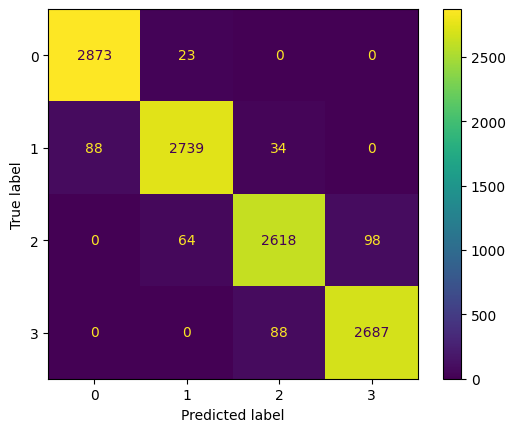

In [35]:
cm = confusion_matrix(y_true,y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [36]:
print ("Classification Report")
print(classification_report(y_true,y_pred))

Classification Report
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      2896
           1       0.97      0.96      0.96      2861
           2       0.96      0.94      0.95      2780
           3       0.96      0.97      0.97      2775

    accuracy                           0.97     11312
   macro avg       0.96      0.96      0.96     11312
weighted avg       0.97      0.97      0.97     11312

